In [1]:
import os
import time
from copy import copy, deepcopy
import json
from itertools import pairwise
from typing import Optional, List

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import models, utils
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from tqdm import tqdm


## Data setup

In [2]:
# import glob

# min_width = min_height = float('inf')
# for p in glob.glob('data/train/**/*.jpg'):
#     image = Image.open(p)
#     min_height = min(image.size[0], min_height)
#     min_width = min(image.size[1], min_width)

In [3]:
# min_height, min_width

In [4]:
class_names = ['like', 'dislike', 'ok']
classes = list(range(len(class_names)))
class_lookup = {n: i for n, i in zip(class_names, classes)}
class_lookup

{'like': 0, 'dislike': 1, 'ok': 2}

In [5]:
class HagridDataset(Dataset):
    def __init__(self, annotations_dir, data_dir, general_transform=None, random_transform=None):
        self.paths = []
        self.labels = []
        self.general_transform = general_transform
        self.random_transform = random_transform
        for class_name in class_names:
            with open(os.path.join(annotations_dir, f"{class_name}.json"), 'r') as f:
                anns = json.load(f)
                all_paths = [os.path.join(data_dir, class_name, f'{name}.jpg') for name in anns.keys()]
                new_paths = all_paths
                self.paths += new_paths 
                self.labels += [class_lookup[class_name]] * len(new_paths)
        self.cache = {}
        self.max_cache = 0 # len(self.paths)

    def __len__(self):
        return len(self.labels)
    
    def _read_image(self, path):
        if path in self.cache:
            image = self.cache[path]
        else:
            image = Image.open(path)
            if self.general_transform:
                image = self.general_transform(image)
            if len(self.cache) < self.max_cache:
                self.cache[path] = image 
        return image
    
    def __getitem__(self, idx):
        img_path = self.paths[idx]
        image = self._read_image(img_path)
        label = self.labels[idx]
        if self.random_transform:
            image = self.random_transform(image)
        return image, label
        
    def clear_cache(self):
        self.cache = {}

Dataset contains 84257 images from 3 classes.
The class 0 has smallest number of samples 27721.
The class 1 has the largest number of samples 28537.


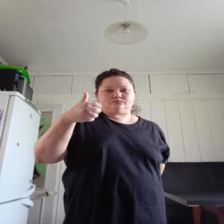

In [6]:
# dataset = HagridDataset('data/ann_subsample/', 'data/subsample/')
dataset = HagridDataset('data/ann_train_val/', 'data/train/')
unique_labels, counts = np.unique(dataset.labels, return_counts=True)
num_classes = len(unique_labels)
print(f'Dataset contains {len(dataset)} images from {num_classes} classes.\nThe class {unique_labels[np.argmin(counts)]} has smallest number of samples {counts.min()}.\n'+\
     f'The class {unique_labels[np.argmax(counts)]} has the largest number of samples {counts.max()}.')
dataset[0][0].resize((224, 224))

In [7]:
train_idx, val_idx = train_test_split(np.arange(len(dataset)),
                                             test_size=0.1,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=dataset.labels)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
train_dataset.dataset = deepcopy(dataset)
val_dataset.dataset = deepcopy(dataset)

train_dataset.dataset.general_transform = None
train_dataset.dataset.random_transform = None
val_dataset.dataset.random_transform = None
val_dataset.dataset.general_transform = None
len(train_dataset), len(val_dataset)

(75831, 8426)

In [8]:
gpu_avail = torch.cuda.is_available()
device = "cuda" if gpu_avail else "cpu"
print(f"Using {device} device")
dataloader_args = {
    'batch_size': 8,
    'shuffle': True,
    # 'num_workers': 2,
    # 'prefetch_factor': 4,
}
if gpu_avail:
    dataloader_args = {**dataloader_args, 'pin_memory': True, 'pin_memory_device': device}

Using cpu device


In [9]:
dataloaders = {name: DataLoader(dataset, **dataloader_args)
               for name, dataset in zip(['train', 'val'], [train_dataset, val_dataset])}

In [10]:
def time_elapsed(start):
    time_elapsed = time.time() - start
    return f'{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'

In [11]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = float('-inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total_images = 0
            running_f1 = 0.0
            f1_count = 0

            batch_start = time.time()
            dl = dataloaders[phase]
            batch_count = len(dl)
            pbar = tqdm(dl, postfix='')
            for i, (inputs, labels) in enumerate(pbar):
                pbar.postfix = f'Batch {i+1}/{batch_count} started after {time_elapsed(batch_start)}'
                batch_start = time.time()

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, dim=1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_f1 += metrics.f1_score(labels.cpu(), preds.cpu(), average='weighted')
                f1_count += 1
                total_images += inputs.shape[0]

            pbar.close()
            if phase == 'train' and scheduler is not None:
                scheduler.step()
            
            epoch_loss = running_loss / total_images
            epoch_acc = running_corrects.double() / total_images
            epoch_f1 = running_f1 / f1_count
            
            print(f'{phase} Total of: {total_images} images | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | F1: {epoch_f1:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                print('New best F1, saving model...')
                best_model_wts = deepcopy(model.state_dict())
                torch.save(best_model_wts, 'model.zip')

        print()

    print(f'Training complete in {time_elapsed(since)}')
    print(f'Best val Acc: {best_acc:4f}')
    print(f'Best val F1: {best_f1:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## AttentionHGR Experiment

In [32]:
def conv(
    in_channels: int,
    out_channels: int,
    kernel_size=3,
    padding=1,
) -> nn.Conv2d:
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=1,
        padding=padding,
        groups=1,
        bias=True,
        dilation=1,
    )


class ConvUnitX(nn.Module):

    def __init__(
        self,
        in_filters: int,
        out_filters: int,
        inter=None,
        post=None,
        mid_filters: Optional[int] = None,
        n: int = 1,
        **conv_args,
    ) -> None:
        super().__init__()
        if mid_filters is None:
            mid_filters = in_filters
        self.inter = inter
        channels = [in_filters] + [mid_filters] * (n - 1) + [out_filters]
        layers: List[nn.Module] = [
            self._make_layer(i, o, **conv_args) for i, o in pairwise(channels)
        ]
        if post is not None:
            layers.append(post)
        self.layers = nn.Sequential(*layers)

    def _make_layer(self, inp: int, out: int, **conv_args):
        c = conv(inp, out, **conv_args)
        if self.inter is None:
            return c
        else:
            return nn.Sequential(c, self.inter(out))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


def conv_unit1(
    in_filters: int,
    out_filters: int,
    mid_filters: Optional[int] = None,
    n: int = 1,
    **conv_args,
):
    return ConvUnitX(
        in_filters,
        out_filters,
        inter=nn.BatchNorm2d,
        mid_filters=mid_filters,
        n=n,
        **conv_args,
    )


def conv_unit2(
    in_filters: int,
    out_filters: int,
    mid_filters: Optional[int] = None,
    n: int = 1,
    **conv_args,
):
    return ConvUnitX(
        in_filters,
        out_filters,
        inter=lambda _: nn.ReLU(),
        post=nn.Dropout2d(),
        mid_filters=mid_filters,
        n=n,
        **conv_args,
    )


def conv_unit3(
    in_filters: int,
    out_filters: int,
    mid_filters: Optional[int] = None,
    n: int = 1,
    add_relu=True,
    **conv_args,
):
    return ConvUnitX(
        in_filters,
        out_filters,
        inter=(lambda _: nn.ReLU()) if add_relu else None,
        post=nn.BatchNorm2d(out_filters),
        mid_filters=mid_filters,
        n=n,
        **conv_args,
    )


class ResidualUnit(nn.Module):

    def __init__(
        self,
        in_filters: int,
        out_filters: int,
        mid_filters: Optional[int] = None,
    ) -> None:
        """mid_filters will be in_filters if it is not provided. mid_filters
        must be less than out_filters and must divide out_filters evenly."""
        super().__init__()
        if mid_filters is None:
            mid_filters = in_filters
        self.mid_out_mult, mod = divmod(out_filters, mid_filters)
        assert mod == 0, 'mid_filters must divide out_filters evenly'
        self.conv1 = conv_unit1(in_filters, mid_filters)
        self.conv2 = conv_unit1(mid_filters, out_filters)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # (batch, mid_filters, w, h)
        x = self.conv1(x)
        # (batch, out_filters, w, h)
        x2 = self.conv2(x)
        x = torch.concat([x for _ in range(self.mid_out_mult)], dim=1)
        return x + x2


class AttentionHGR(nn.Module):

    def __init__(self, num_classes: int) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.feature_extractor1 = conv_unit1(3, 1024, mid_filters=256, n=6)
        self.feature_extractor2 = conv_unit1(1027, 1024, mid_filters=256, n=6)
        self.spatial_attention = nn.Sequential(
            ResidualUnit(3, 128, mid_filters=128),
            ResidualUnit(128, 256),
            conv_unit1(256, 1024, n=2),
        )
        self.second_attention = nn.Sequential(
            ResidualUnit(1027, 128, mid_filters=128),
            ResidualUnit(128, 256),
            conv_unit1(256, 1024, n=2),
        )
        self.classifier = nn.Sequential(
            conv_unit2(1024, 96, padding='same'),
            conv_unit2(96, 96, n=2, padding='same'),
            nn.MaxPool2d(2),
            conv_unit2(96, 192, mid_filters=192, n=3, padding='same'),
            nn.MaxPool2d(2),
            conv_unit3(192, 192, n=2, padding='same'),
            conv_unit3(192,
                       num_classes,
                       add_relu=False,
                       kernel_size=1,
                       padding='valid'),
            nn.AvgPool2d(40),
            nn.Softmax(dim=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attention_mask = self.spatial_attention(x)
        features = self.feature_extractor1(x)
        mc = torch.concat([attention_mask * features, x], dim=1)
        attention_mask = self.second_attention(mc)
        features = self.feature_extractor2(mc)
        fss = attention_mask * features
        # We reshape here to make the output compatible with our training function
        return self.classifier(fss).reshape((-1, self.num_classes))


In [13]:
AttentionHGR(num_classes)

AttentionHGR(
  (feature_extractor1): ConvUnitX(
    (layers): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (4): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [33]:
def print_sizes(model, input_tensor):
    output = input_tensor
    for m in model.children():
        output = m(output)
        print(m, output.shape)
    return output

m = AttentionHGR(num_classes)

In [36]:
dl = dataloaders['val']
dl.dataset.dataset.general_transform = T.Compose(
    [T.ToTensor(), T.Resize((160, 160), antialias=True)])
for inputs, labels in dl:
    outputs = m(inputs[:3])
    print(outputs)
    print(outputs.shape)
    break

tensor([[0.3209, 0.3591, 0.3200],
        [0.3981, 0.3319, 0.2699],
        [0.2816, 0.3019, 0.4165]], grad_fn=<ReshapeAliasBackward0>)
torch.Size([3, 3])


In [37]:
print(torch.max(outputs, dim=1))

torch.return_types.max(
values=tensor([0.3591, 0.3981, 0.4165], grad_fn=<MaxBackward0>),
indices=tensor([1, 0, 2]))


In [31]:
del outputs

In [33]:
cu1 = conv_unit1(3, 256, mid_filters=128, n=2)
cu1

ConvUnitX(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)

In [37]:
conv_unit2(3, 256, mid_filters=128, n=3)

ConvUnitX(
  (layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Dropout2d(p=0.5, inplace=False)
  )
)

In [38]:
conv_unit3(3, 256, mid_filters=128, n=3)

ConvUnitX(
  (layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [17]:
ResidualUnit(128, 256)

ResidualUnit(
  (conv1): ConvUnit1(
    (layers): Sequential(
      (0): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (conv2): ConvUnit1(
    (layers): Sequential(
      (0): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
)

## Mobilenet Experiment

In [17]:
def mk_mobilenet(pretrained=True):
    weights = models.MobileNet_V3_Large_Weights.DEFAULT
    transforms = weights.transforms(antialias=True)
    m = models.mobilenet_v3_large(weights=weights if pretrained else None)
    m.features.requires_grad = False
    m.classifier[3] = nn.Linear(m.classifier[3].in_features, num_classes)

    m = m.to(device)
    return m, transforms

pretrained, transforms = mk_mobilenet(pretrained=True)

criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(pretrained.fc.parameters(), lr=0.001)
optimizer = optim.SGD([{'params': pretrained.classifier.parameters(),
                        # 'params': pretrained.fc.parameters(),
                        # 'params': l4params, 'lr': 0.01
                        }],
                    #   weight_decay=0.1,
                      lr=0.001,
                      momentum=0.9)
# optimizer = optim.SGD(pretrained.classifier.parameters(), weight_decay=0.001, lr=0.1, momentum=0.9)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [ ]:
for dl in dataloaders.values():
    dl.dataset.dataset.clear_cache()
    dl.dataset.dataset.general_transform = T.Compose([T.ToTensor(), transforms])

### Train the head

In [12]:
model = train_model(pretrained, criterion, optimizer, lr_scheduler, dataloaders=dataloaders, num_epochs=5)

Epoch 1/5
----------


100%|██████████| 149/149 [1:28:41<00:00, 35.71s/it, Batch 149/149 started after 0m 35s]


train Total of: 75831 images | Loss: 1.0663 | Acc: 0.4321 | F1: 0.4291


100%|██████████| 17/17 [02:48<00:00,  9.90s/it, Batch 17/17 started after 0m 10s]


val Total of: 8426 images | Loss: 1.0183 | Acc: 0.5309 | F1: 0.5256
New best F1, saving model...

Epoch 2/5
----------


  0%|          | 0/149 [00:03<?, ?it/s, Batch 1/149 started after 0m 1s]


KeyboardInterrupt: 

### Train everything

In [15]:
# w = torch.load('model.zip')
# model = pretrained
# model.load_state_dict(w)
# print(type(model))

<class 'torchvision.models.mobilenetv3.MobileNetV3'>


In [16]:
model.features.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
# optimizer = optim.SGD([{'params': model.classifier.parameters(),
#                         # 'params': model.fc.parameters(),
#                         # 'params': l4params, 'lr': 0.01
#                         }],
#                     #   weight_decay=0.1,
#                       lr=0.05,
#                       momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
model = train_model(model, criterion, optimizer, lr_scheduler, dataloaders=dataloaders, num_epochs=5)

Epoch 1/5
----------


100%|██████████| 149/149 [1:29:27<00:00, 36.02s/it, Batch 149/149 started after 0m 35s]


train Total of: 75831 images | Loss: 0.2390 | Acc: 0.9081 | F1: 0.9084


100%|██████████| 17/17 [02:53<00:00, 10.21s/it, Batch 17/17 started after 0m 10s]


val Total of: 8426 images | Loss: 0.0834 | Acc: 0.9681 | F1: 0.9686
New best F1, saving model...

Epoch 2/5
----------


100%|██████████| 149/149 [1:30:34<00:00, 36.48s/it, Batch 149/149 started after 0m 35s]


train Total of: 75831 images | Loss: 0.0579 | Acc: 0.9784 | F1: 0.9785


100%|██████████| 17/17 [02:53<00:00, 10.22s/it, Batch 17/17 started after 0m 10s]


val Total of: 8426 images | Loss: 0.0705 | Acc: 0.9735 | F1: 0.9740
New best F1, saving model...

Epoch 3/5
----------


100%|██████████| 149/149 [1:29:57<00:00, 36.23s/it, Batch 149/149 started after 0m 35s]


train Total of: 75831 images | Loss: 0.0308 | Acc: 0.9886 | F1: 0.9885


100%|██████████| 17/17 [02:55<00:00, 10.33s/it, Batch 17/17 started after 0m 10s]


val Total of: 8426 images | Loss: 0.0538 | Acc: 0.9797 | F1: 0.9797
New best F1, saving model...

Epoch 4/5
----------


100%|██████████| 149/149 [1:29:42<00:00, 36.13s/it, Batch 149/149 started after 0m 36s]


train Total of: 75831 images | Loss: 0.0147 | Acc: 0.9947 | F1: 0.9945


100%|██████████| 17/17 [02:52<00:00, 10.17s/it, Batch 17/17 started after 0m 10s]


val Total of: 8426 images | Loss: 0.0654 | Acc: 0.9801 | F1: 0.9804
New best F1, saving model...

Epoch 5/5
----------


100%|██████████| 149/149 [1:30:46<00:00, 36.55s/it, Batch 149/149 started after 0m 36s]


train Total of: 75831 images | Loss: 0.0098 | Acc: 0.9967 | F1: 0.9967


100%|██████████| 17/17 [02:55<00:00, 10.33s/it, Batch 17/17 started after 0m 10s]

val Total of: 8426 images | Loss: 0.0736 | Acc: 0.9803 | F1: 0.9805
New best F1, saving model...

Training complete in 465m 1s
Best val Acc: 0.980299
Best val F1: 0.980532


### Train on validation

In [17]:
dl_val_train = deepcopy(dataloaders)
dl_val_train['train'] = dataloaders['val']
model = train_model(model, criterion, optimizer, lr_scheduler, dataloaders=dl_val_train, num_epochs=5)

Epoch 1/5
----------


100%|██████████| 17/17 [09:14<00:00, 32.60s/it, Batch 17/17 started after 0m 34s]


train Total of: 8426 images | Loss: 0.0607 | Acc: 0.9827 | F1: 0.9831


100%|██████████| 17/17 [02:46<00:00,  9.80s/it, Batch 17/17 started after 0m 10s]


val Total of: 8426 images | Loss: 0.0355 | Acc: 0.9849 | F1: 0.9849
New best F1, saving model...

Epoch 2/5
----------


100%|██████████| 17/17 [09:36<00:00, 33.90s/it, Batch 17/17 started after 0m 34s]


train Total of: 8426 images | Loss: 0.0215 | Acc: 0.9931 | F1: 0.9932


100%|██████████| 17/17 [02:47<00:00,  9.87s/it, Batch 17/17 started after 0m 10s]


val Total of: 8426 images | Loss: 0.0287 | Acc: 0.9875 | F1: 0.9876
New best F1, saving model...

Epoch 3/5
----------


100%|██████████| 17/17 [09:38<00:00, 34.01s/it, Batch 17/17 started after 0m 35s]


train Total of: 8426 images | Loss: 0.0116 | Acc: 0.9968 | F1: 0.9969


100%|██████████| 17/17 [02:49<00:00,  9.98s/it, Batch 17/17 started after 0m 10s]


val Total of: 8426 images | Loss: 0.0162 | Acc: 0.9926 | F1: 0.9929
New best F1, saving model...

Epoch 4/5
----------


100%|██████████| 17/17 [09:40<00:00, 34.14s/it, Batch 17/17 started after 0m 35s]


train Total of: 8426 images | Loss: 0.0067 | Acc: 0.9981 | F1: 0.9982


100%|██████████| 17/17 [02:44<00:00,  9.65s/it, Batch 17/17 started after 0m 10s]


val Total of: 8426 images | Loss: 0.0106 | Acc: 0.9961 | F1: 0.9958
New best F1, saving model...

Epoch 5/5
----------


100%|██████████| 17/17 [09:46<00:00, 34.47s/it, Batch 17/17 started after 0m 35s]


train Total of: 8426 images | Loss: 0.0043 | Acc: 0.9986 | F1: 0.9986


100%|██████████| 17/17 [02:50<00:00, 10.00s/it, Batch 17/17 started after 0m 10s]

val Total of: 8426 images | Loss: 0.0079 | Acc: 0.9976 | F1: 0.9977
New best F1, saving model...

Training complete in 61m 54s
Best val Acc: 0.997626
Best val F1: 0.997704


### Evaluation

Dataset contains 7357 images from 3 classes.
The class 2 has smallest number of samples 2391.
The class 1 has the largest number of samples 2551.


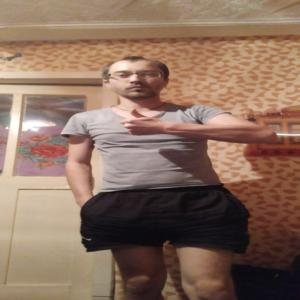

In [12]:
test_dataset = HagridDataset('data/ann_test/', 'data/test/')
unique_labels, counts = np.unique(test_dataset.labels, return_counts=True)
num_classes = len(unique_labels)
print(f'Dataset contains {len(test_dataset)} images from {num_classes} classes.\nThe class {unique_labels[np.argmin(counts)]} has smallest number of samples {counts.min()}.\n'+\
     f'The class {unique_labels[np.argmax(counts)]} has the largest number of samples {counts.max()}.')
test_dataset[0][0]

In [14]:
test_dataset.clear_cache()
test_dataset.general_transform = T.Compose([T.ToTensor(), transforms])
test_dataloader = DataLoader(test_dataset, **dataloader_args)

In [46]:
def get_predictions(model, dataloader):
    was_training = model.training
    model.eval()
    inputs = [] 
    predictions = [] 
    labels = []
    with torch.no_grad():
        batch_start = time.time()
        batch_count = len(dataloader)
        pbar = tqdm(dataloader, postfix='')
        for i, (batch_inputs, batch_labels) in enumerate(pbar):
            pbar.postfix = f'Batch {i+1}/{batch_count} started after {time_elapsed(batch_start)}'
            batch_start = time.time()
            batch_inputs = batch_inputs.to(device)

            outputs = model(batch_inputs)
            _, preds = torch.max(outputs, 1)
            inputs += list(batch_inputs)
            predictions += list(map(int, preds))
            labels += list(map(int, batch_labels))

    model.train(mode=was_training)
    return inputs, predictions, labels

In [27]:
w = torch.load('models/examples-all/mobilenetv3-large-final.zip')
model_trained, transforms = mk_mobilenet(pretrained=False)
model_trained.load_state_dict(w)
print(type(model_trained))

<class 'torchvision.models.mobilenetv3.MobileNetV3'>


In [47]:
inputs, predictions, labels = get_predictions(model_trained, test_dataloader)

100%|██████████| 15/15 [02:38<00:00, 10.57s/it, Batch 15/15 started after 0m 10s]


In [37]:
print(len(test_dataset))
print(len(predictions), len(labels))
print(predictions[:5], labels[:5])

7357
7357 7357
[0, 2, 2, 0, 0] [0, 2, 2, 0, 0]


In [61]:
print(metrics.classification_report(labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

        like       0.94      0.99      0.96      2415
     dislike       0.99      0.97      0.98      2551
          ok       0.99      0.96      0.98      2391

    accuracy                           0.97      7357
   macro avg       0.97      0.97      0.97      7357
weighted avg       0.97      0.97      0.97      7357



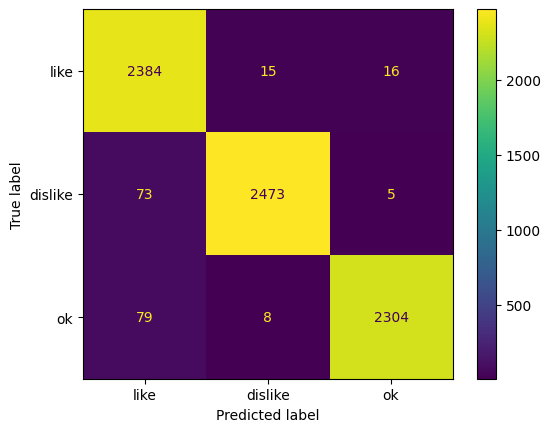

In [58]:
metrics.ConfusionMatrixDisplay.from_predictions(labels, predictions, display_labels=class_names)

In [62]:
def visualize_model(model, num_images=6):
    "Based off https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html"
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for pred, label, input in zip(predictions, labels, inputs):
            if pred != label:
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[pred]}')
                plt.imshow(input.cpu().numpy().transpose((1, 2, 0)))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


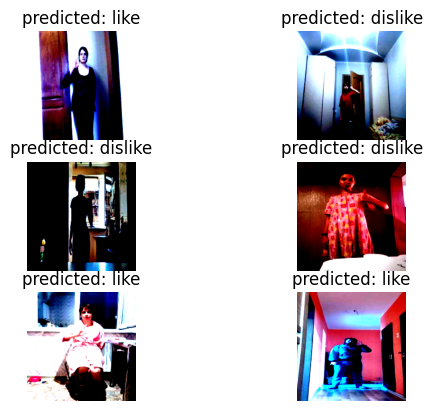

In [63]:
visualize_model(model_trained)